In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pendulum_env import PendulumEnvironment
import tiles3 as tc
import jdc

In [2]:
env_test = PendulumEnvironment()
env_test.env_init(), env_test.env_start(), env_test.env_step(1)

(None,
 array([-3.14159265,  0.        ]),
 (-3.141592653589793, array([-3.14159265e+00, -3.00038466e-17]), False))

In [3]:
class PendulumTileCoder:
    def __init__(self, iht_size=4096, num_tilings=32, num_tiles=8):
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
        self.iht_size = iht_size
        self.iht = tc.IHT(iht_size)
    
    def get_tiles(self, state):
        angle_scaled = ( (state[0] + np.pi)  / (2*np.pi) ) * self.num_tiles
        ang_vel_scaled = ( (state[1] + 2*np.pi) / ( 4*np.pi) ) * self.num_tiles

        tiles = tc.tileswrap(self.iht, self.num_tilings, [angle_scaled, ang_vel_scaled], wrapwidths=[self.num_tiles, False])
        return np.array(tiles)

In [4]:
class ActorCriticSoftmax: 
    def __init__(self, environment, tileCoding, actor_alpha, critic_alpha, reward_alpha, gamma=1):
        self.env = environment
        self.tc = tileCoding
        self.actions = list(range(3))
        self.actor_alpha = actor_alpha/self.tc.num_tilings
        self.critic_alpha = critic_alpha/self.tc.num_tilings
        self.reward_alpha = reward_alpha
        self.gamma = gamma
        self.avg_reward = 0.0
        self.actor_w = np.zeros((len(self.actions), self.tc.iht_size))
        self.critic_w = np.zeros(self.tc.iht_size)


    def reset(self):
        self.avg_reward = 0.0
        self.actor_w = np.zeros((len(self.actions), self.tc.iht_size))
        self.critic_w = np.zeros(self.tc.iht_size)


In [5]:
%%add_to ActorCriticSoftmax

def agent_policy(self, state_tiles):
    action_preferences = self.actor_w[:, state_tiles].sum(axis=1)    
    normalized_preferences = action_preferences - np.max(action_preferences) 
    softmax_prob = np.exp(normalized_preferences) / np.sum(np.exp(normalized_preferences))
    chosen_action = np.random.choice(self.actions, p=softmax_prob)
    
    return chosen_action, softmax_prob

In [6]:
%%add_to ActorCriticSoftmax

def estimate(self, n_steps):
    rewards = np.zeros(n_steps)
    self.env.env_init()
    state = self.env.env_start()
    state_tiles = self.tc.get_tiles(state)
    I_gamma = 1

    for step in range(n_steps):
        action, softmax_prob = self.agent_policy(state_tiles)        
        reward, state_p, _ = self.env.env_step(action)
        rewards[step] = reward
        state_p_tiles = self.tc.get_tiles(state_p)

        delta = reward - self.avg_reward + self.gamma * self.critic_w[state_p_tiles].sum() - self.critic_w[state_tiles].sum()
    
        self.avg_reward += self.reward_alpha * delta
        self.critic_w[state_tiles] += self.critic_alpha * delta
        for a in self.actions:
            if a == action:
                self.actor_w[a][state_tiles] += self.actor_alpha * I_gamma * delta * (1 - softmax_prob[a])
            else:
                self.actor_w[a][state_tiles] += self.actor_alpha * I_gamma * delta * (0 - softmax_prob[a])

        state_tiles = state_p_tiles
        I_gamma *= self.gamma

    return rewards

In [7]:
%%add_to ActorCriticSoftmax

def iterate(self, n_runs, n_steps):
    rewards = np.zeros(n_steps)
    for _ in tqdm(range(n_runs)):
        self.reset()
        rewards += self.estimate(n_steps)

    return rewards / n_runs

In [8]:
env = PendulumEnvironment()
ptc = PendulumTileCoder(iht_size=4096, num_tilings=32, num_tiles=8)

agent = ActorCriticSoftmax(env, ptc, actor_alpha=2**(-2), critic_alpha=2, reward_alpha=2**(-6), gamma=1)

res = agent.iterate(50, 20000)


100%|██████████| 50/50 [02:28<00:00,  2.98s/it]


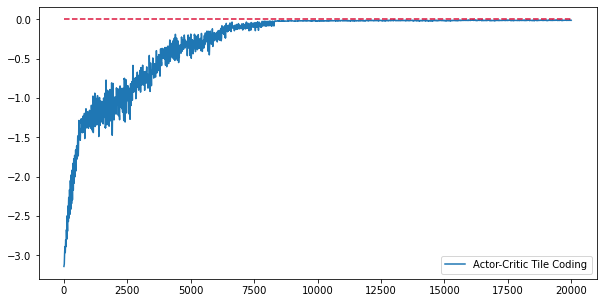

In [9]:
plt.figure(figsize=(10,5))
plt.plot(res, label='Actor-Critic Tile Coding')
plt.plot([0,20000],[0,0], '--', color='crimson')
plt.legend()
plt.show()